In [1]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1

In [2]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [3]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit4/requirements-unit4.txt

  Cloning https://github.com/ntasfi/PyGame-Learning-Environment.git to /tmp/pip-req-build-xq8_j8oi
  Running command git clone --filter=blob:none --quiet https://github.com/ntasfi/PyGame-Learning-Environment.git /tmp/pip-req-build-xq8_j8oi
  Resolved https://github.com/ntasfi/PyGame-Learning-Environment.git to commit 3dbe79dc0c35559bb441b9359948aabf9bb3d331
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/simoninithomas/gym-games to /tmp/pip-req-build-pzko5b1q
  Running command git clone --filter=blob:none --quiet https://github.com/simoninithomas/gym-games /tmp/pip-req-build-pzko5b1q
  Resolved https://github.com/simoninithomas/gym-games to commit f31695e4ba028400628dc054ee8a436f28193f0b
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 8.2 MB/s eta 0:00:00
  Created wheel for ple: filename=ple-0.0.1-py3-none-any.whl size=50771 sha256=8842bf24e2f6c7c8851c49c478614fac84b034be8fc00b5ed3184dc37496a82b
  Stored in dire

In [4]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
import gym_pygame

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
env= gym.make("CartPole-v1")
eval_env = gym.make("CartPole-v1")

In [14]:
print("Observation Space_______________________________________/n")
print(env.observation_space.shape[0])
print(env.observation_space.high)
print(env.observation_space.low)
print("Action Space_______________________________________/n")
print(env.action_space)
print(env.action_space.n)

Observation Space_______________________________________/n
4
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Action Space_______________________________________/n
Discrete(2)
2


In [26]:
class policy(nn.Module):
  def __init__(self, s_size, a_size, h_size):
    super(policy, self).__init__()
    self.fc1 = nn.Linear(4, 128)
    self.fc2 = nn.Linear(128, 2)
  def forward(self,x):
    out = F.relu(self.fc1(x))
    out = self.fc2(out)
    return F.softmax(out, dim=1)
  def action(self, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    probs = self.forward(state).cpu() #tensor of probabilities
    m = Categorical(probs) #discrete dist.
    action = m.sample()
    return action.item(), m.log_prob(action)

In [25]:
debug_policy = policy(env.observation_space.shape[0], env.action_space.n, 64).to(device)
debug_policy.action(env.reset())

(1, tensor([-0.7917], grad_fn=<SqueezeBackward1>))

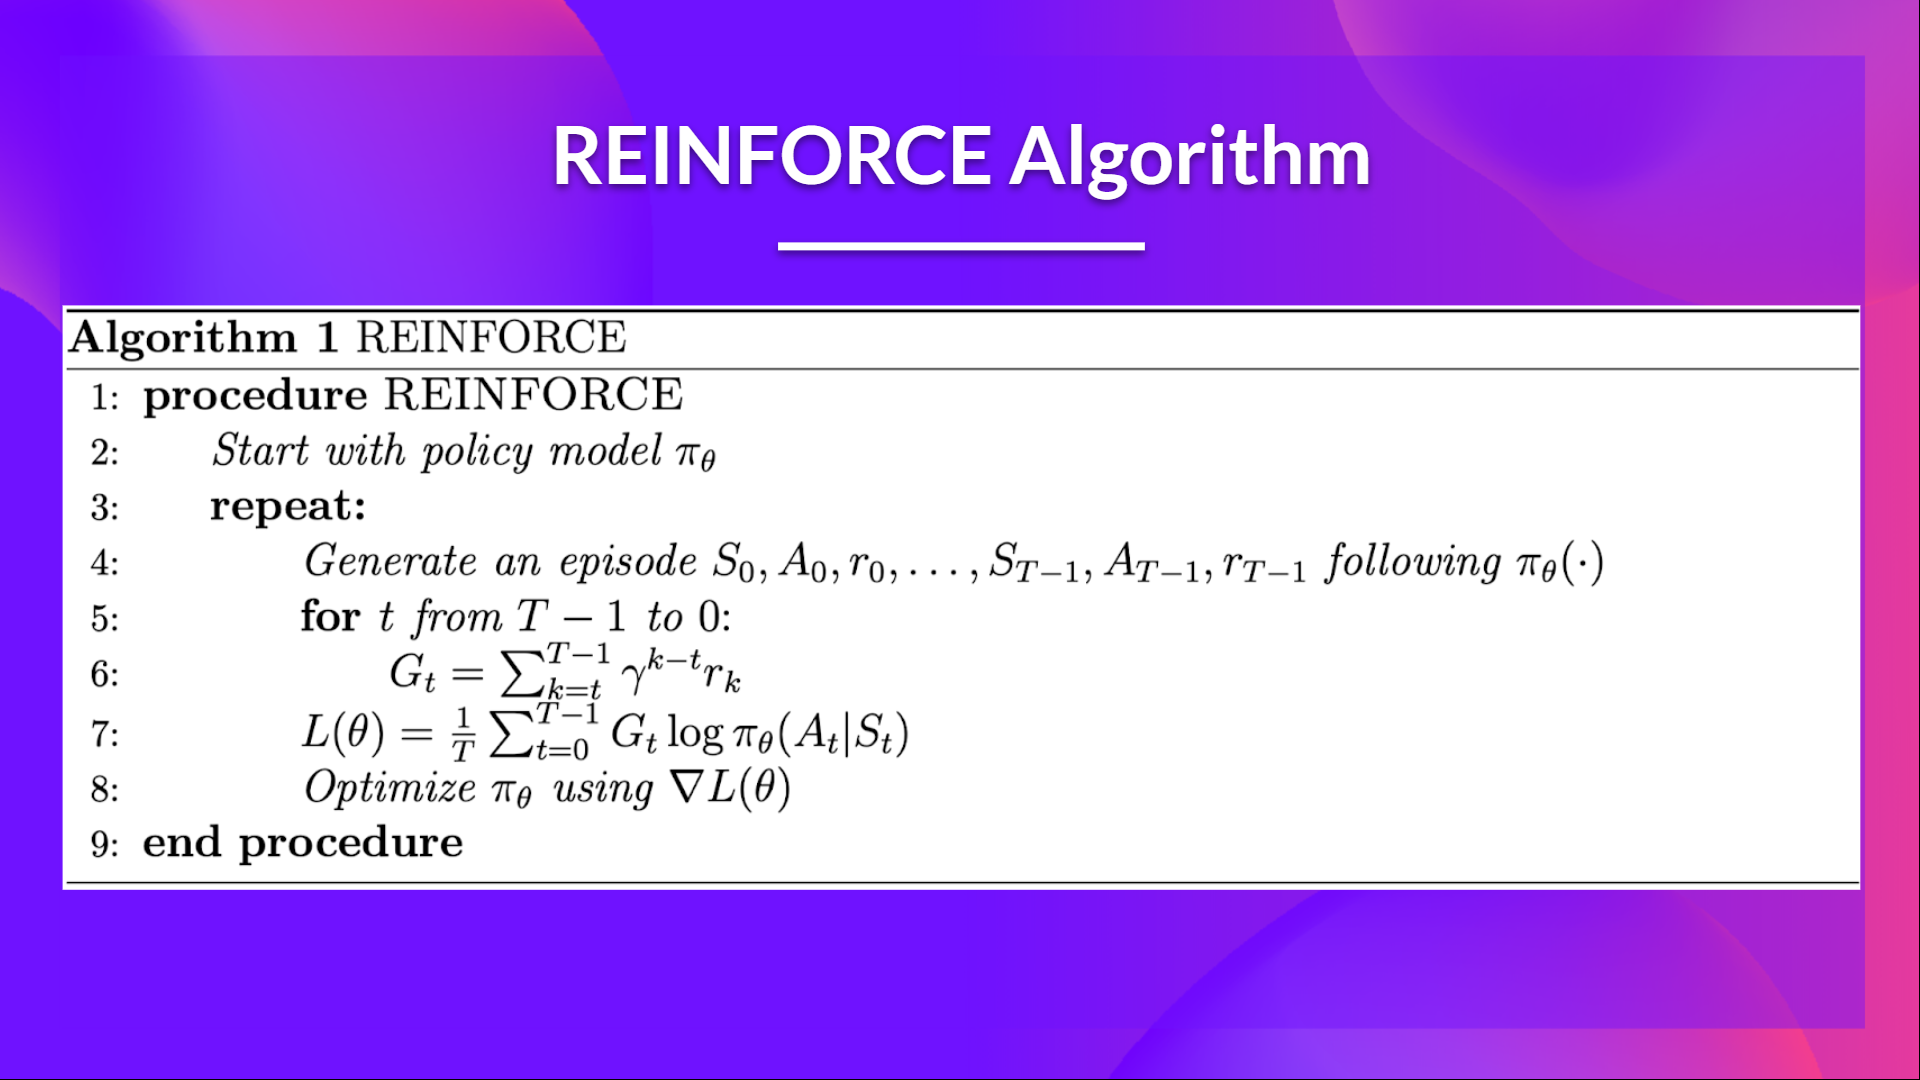

In [35]:
#reinforcement algo
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):

    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()

        for t in range(max_t):
            action, log_prob = policy.action(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )

        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [29]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1500,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": "CartPole-v1",
    "state_space": env.observation_space.shape[0],
    "action_space": env.action_space.n,
}

In [32]:
cartpole_policy = policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

In [36]:
scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 153.54
Episode 200	Average Score: 118.26
Episode 300	Average Score: 148.37
Episode 400	Average Score: 182.95
Episode 500	Average Score: 296.31
Episode 600	Average Score: 139.01
Episode 700	Average Score: 125.14
Episode 800	Average Score: 163.99
Episode 900	Average Score: 476.76
Episode 1000	Average Score: 344.93
Episode 1100	Average Score: 420.57
Episode 1200	Average Score: 500.00
Episode 1300	Average Score: 500.00
Episode 1400	Average Score: 495.14
Episode 1500	Average Score: 171.65


In [39]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.action(state)
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [40]:
evaluate_agent(eval_env,
               cartpole_hyperparameters["max_t"],
               cartpole_hyperparameters["n_evaluation_episodes"],
               cartpole_policy)

(15.9, 6.774215821775979)